<a href="https://colab.research.google.com/github/msuribec/AppliedML_Python_Coursera/blob/master/Manipulacion_tensores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manipulación de Tensores como imágenes

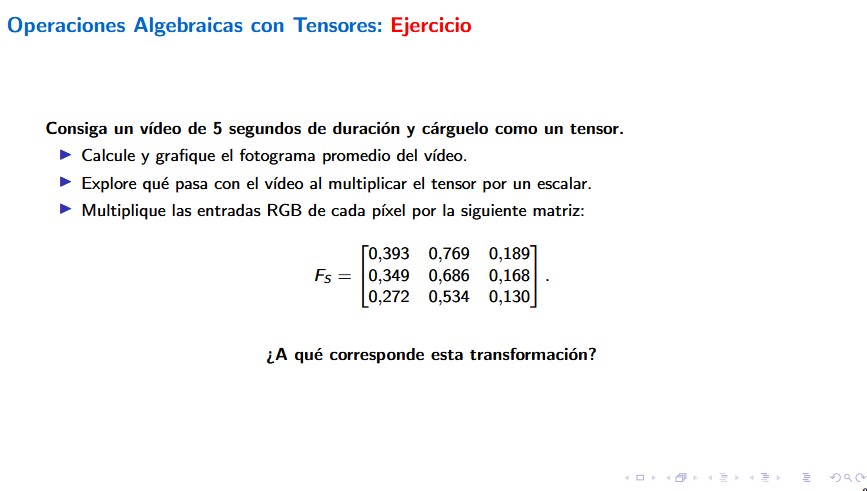

In [ ]:
!pip install pytubefix

In [ ]:
from pytubefix import YouTube
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub
import numpy as np
from IPython.display import HTML
from base64 import b64encode
import os
from tqdm import tqdm

In [ ]:
def create_folders_if_not_exist(folder_paths):
    """Function to create folders if they don't exist
    Parameters
    ----------
    folder_paths : list
    List of paths to folders
    """
    for folder_path in folder_paths:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

In [ ]:
class imageFilter:

    def __init__(self, path_video = None, url_video= None):
        if path_video is None and url_video is None:
            print("Must provide a path to a video file or a youtube url to a video ")
        else:
            if path_video is not None:
                self.path_video = path_video
            else:
                self.url_video = url_video

        self.Results_path = 'Results'
        self.frames_path  = f'{self.Results_path}/Frames'
        self.output_video_path = f'{self.Results_path}/edited_video.mp4'
        create_folders_if_not_exist([self.Results_path,self.frames_path])

    def download_youtube_video(self,resolution='highest'):
        try:
            yt = YouTube(self.url_video)
            print(f"Downloading: {yt.title}")

            if resolution == 'highest':
                stream = yt.streams.get_highest_resolution()
            else:
                stream = yt.streams.filter(res=resolution).first()

            if stream:
                stream.download()
                print("Download complete!")
            else:
                print(f"No stream found with resolution: {resolution}")
            self.video_title = yt.title
            self.path_video = f"{self.video_title}.mp4"
        except Exception as e:
            print(f"An error occurred: {e}")

    def capture_video(self):
        self.video_capture = cv2.VideoCapture(self.path_video)
        self.fps = int(self.video_capture.get(cv2.CAP_PROP_FPS))
        self.W = int(self.video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.H = int(self.video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))


    def save_frames_from_video(self):
        """Function to save frames from video
        """
        video_frames = []
        imgs = []
        list_img_tensors = []

        if self.video_capture.isOpened():
            i = 0
            ret = True
            while ret:
                ret, frame = self.video_capture.read()
                if ret:
                    frame_path = f"{self.frames_path}/{i}.png"
                    video_frames.append(frame)
                    cv2.imwrite(frame_path, frame)
                    tensor_img = self.to_tensor(numpy_img= frame)
                    list_img_tensors.append(tensor_img)
                    img = self.load_img(tensor_img)
                    imgs.append(img)
                i += 1
            self.video_capture.release()
        cv2.destroyAllWindows()

        self.C = video_frames[0].shape[-1]
        self.size = (self.W, self.H)
        self.tensor_list = list_img_tensors


    def to_tensor(self,numpy_img= None, path_to_img=None):
        """Function to convert an image to a tensor, the argument can
        be the numpy array representing the image or the path to the image

        Parameters
        ----------
        numpy_img : np.ndarray, optional
            Numpy array representing an image, by default None
        path_to_img : str, optional
            Path to an image, by default None
        Returns
        -------
        tensor
            Tensor representing an image
        """

        got_args = numpy_img is not None or path_to_img is not None
        assert got_args, "Must pass in either numpy_img or path_to_img"

        if numpy_img is not None:
            flipped = (numpy_img[:, :, ::-1]).astype(int)
            img = tf.convert_to_tensor(flipped, dtype=tf.uint8)
        else:
            img = tf.io.read_file(path_to_img)
            img = tf.image.decode_image(img, channels=3)
        return img

    def tensor_to_image(self,tensor):
        """
        Function to convert a tensor to an image
        Code obtained from tensorflow tutorials page
        Source: https://www.tensorflow.org/tutorials/generative/style_transfer
        Parameters
        ----------
        tensor : tensor
            Tensor to be converted to image
        Returns
        -------
        np.ndarray
            Image converted from tensor
        """
        tensor = tensor*255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor)>3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        return np.squeeze(tensor)

    def load_img(self,img_tensor):
        """ Function that loads an image and resizes it to 512x512
        Code adapted from tensorflow tutorials page
        Source: https://www.tensorflow.org/tutorials/generative/style_transfer
        Parameters:
        ----------
        img_tensor: tensor
            Tensor representing an image
        Returns:
        -------
        tensor
            Tensor representing an image
        """
        max_dim = 512
        img = tf.image.convert_image_dtype(img_tensor, tf.float32)
        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim
        new_shape = tf.cast(shape * scale, tf.int32)
        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img

    def compute_average_frame(self):
        self.average_frame = np.sum(self.tensor_list, axis=0)//len(self.tensor_list)

    def scale_frames(self, scalar):
      tensor_list_multiplied = [np.multiply(t,scalar) for  t in self.tensor_list]
      return tensor_list_multiplied

    def normalize_rgb(self, frame):
      min_vals = frame.min(axis=(0, 1), keepdims=True)  # Min for each channel
      max_vals = frame.max(axis=(0, 1), keepdims=True)  # Max for each channel

      normalized_tensor = (frame - min_vals) / (max_vals - min_vals)
      return normalized_tensor

    def transform_frame(self, frame, filter_image, method = 'multiplication', params = None):
      if method == 'multiplication':
        result = np.tensordot(frame, filter_image, axes=params['axes'])
      elif method == 'einsum':
        result = np.einsum(params['path'], frame, filter_image)
      else:
        raise Exception('Method not supported')
      return self.normalize_rgb(result)


    def transform_frames(self, filter_image, **kwargs):
      new_frames = []
      for frame in self.tensor_list:
        new_frames.append(self.transform_frame(frame, filter_image, **kwargs))
      return new_frames

    def save_video(self, tensor_list, output_path):
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), self.fps, self.size)
        for tensor_ in tensor_list:
            image = self.tensor_to_image(tensor_)
            image = cv2.resize(image, self.size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            out.write(image)

        out.release()

In [ ]:
video_url = "https://www.youtube.com/watch?v=Jw9H_OdcKC8&pp=ygUNNSBzZWNvbmQgbWVtZQ%3D%3D"
image_filter= imageFilter(url_video = video_url)
image_filter.download_youtube_video()
image_filter.capture_video()
image_filter.save_frames_from_video()
image_filter.compute_average_frame()

Downloading: El Risitas Laugh Meme template (5  Sec)
Download complete!


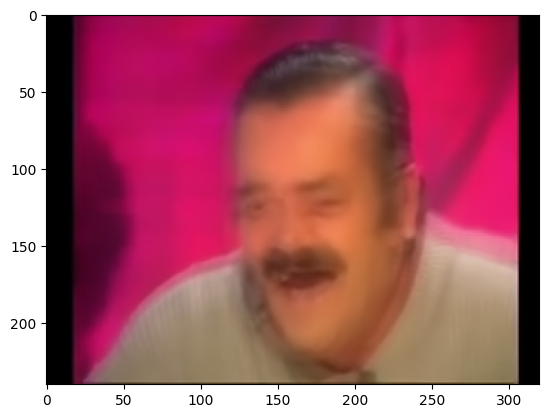

In [ ]:
plt.imshow(image_filter.average_frame)

In [ ]:
tensor_list_multiplied = image_filter.scale_frames(3)

In [ ]:
image_filter.save_video(tensor_list_multiplied, 'Results/filer_video.mp4')

In [ ]:
# Input video path
save_path = 'Results/filer_video.mp4'
# Compressed video path
compressed_path = "Results/filer_video_compressed.mp4"
vidshow(save_path, compressed_path)
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
aux = [[0.393, 0.769, 0.189], [0.349, 0.686, 0.168], [0.272, 0.534, 0.130]]
f_s = np.array(aux)

In [ ]:
normalized_tensors_1 = image_filter.transform_frames(f_s, method = 'einsum', params = {'path': 'ijk,kl->ijl'})
normalized_tensors_2 = image_filter.transform_frames(f_s, method = 'multiplication', params = {'axes': (2, 0)})

In [ ]:
image_filter.save_video(normalized_tensors_1, 'Results/sepia_video_1.mp4')
image_filter.save_video(normalized_tensors_2, 'Results/sepia_video_2.mp4')

In [ ]:
# Input video path
save_path = 'Results/sepia_video_1.mp4'
# Compressed video path
compressed_path = "Results/sepia_compressed_1.mp4"
vidshow(save_path, compressed_path)
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# Input video path
save_path = 'Results/sepia_video_2.mp4'
# Compressed video path
compressed_path = "Results/sepia_compressed_2.mp4"
vidshow(save_path, compressed_path)
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)